In [8]:
import json
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from matplotlib import rcParams
color = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot():
    # from matplotlib import rcParams
    # rcParams['font.family'] = 'Times New Roman'
    # rcParams['font.sans-serif'] = 'Times New Roman'
    # rcParams['axes.unicode_minus'] = False
    # rcParams['font.size'] = 18
    font = {'family': 'serif',
        'weight': 'normal', 'size': 12}
    plt.rc('font', **font)
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    return None
    

In [9]:
# eff area
vmin = 1e-1
vmax = 5e2
cos_zenith_edge = np.array([-1, 1])
cos_zenith_bins = np.linspace(-1, 1, 11)
log_energy_bins = np.linspace(3, 5, 11)
file1 = '/lustre/neutrino/wangyingwei/project/9_1/data1.csv'
file1_1 = '/lustre/neutrino/changqichao/trident/100/9_1/data1.csv'
file2 = '/lustre/neutrino/wangyingwei/data/shower/10_100TeV/batch0/data/mc_events.json'
filename = 'eff_area'
antares = False
km3net = False

In [3]:
def energy_zenith_weight(file1: str, file2: str = None):
    if file2 == None:
        #file2 = '/lustre/neutrino/changqichao/event-generator/build/bin/mc_events_0.json'
        #file2 = '/lustre/neutrino/changqichao/data/100/9_1/mc_events_0.json'
        file2 = '/lustre/neutrino/wangyingwei/data/shower/10_100TeV/batch0/data/mc_events.json'
    with open(file2,'r',encoding='utf8')as fp:
        json_data = json.load(fp)
    data = pd.read_csv(file1)
    angle = data['angle'].to_list()
    npe = data['npe'].to_list()
    trigger = data['trigger'].to_list()


    energy = []
    zenith = []
    weight_total = []
    weight_select = np.zeros(len(angle))
    # num = 0
    time = len(angle) / len(json_data)
    for k in range(round(time)):
        for i in range(len(json_data)):
            px = json_data[i]["particles_in"][0]["px"]
            py = json_data[i]["particles_in"][0]["py"]
            pz = json_data[i]["particles_in"][0]["pz"]
            energy_particle = np.sqrt(px**2 + py**2 + pz**2)
            zenith_particle = pz / energy_particle
            energy.append(energy_particle)
            zenith.append(zenith_particle)
            total = json_data[i]["weights"]["total"]
            weight_total.append(total)
            # if angle[i] >= 0:
            #     weight_select[i] = 1
            if trigger[i+k*len(json_data)] == True:
                weight_select[i+k*len(json_data)] = 1
            # if npe[i+k*len(json_data)] >= 1 :
            #     weight_select[i+k*len(json_data)] = 1
            # if total >0 :
            #     if len(json_data[i]["particles_at_detector"]) >0:
            #         if json_data[i]["particles_at_detector"][0]['pdgid'] ==13 :
            #             num+=1
    energy = np.array(energy)
    zenith = np.array(zenith)
    weight_total = np.array(weight_total)
    weight = weight_total * weight_select
    return energy, zenith, weight

In [4]:
def get_eff_area(cos_zenith_bins, log_energy_bins, 
                  file1: str, file2: str = None):
    energy, cos_zenith, weight = energy_zenith_weight(file1, file2)

    num_tot_weighted = np.histogram2d(
        x=cos_zenith, y=np.log10(energy), weights=weight,
        bins=[cos_zenith_bins, log_energy_bins])[0]
    bins_size = 2 * np.pi * \
        np.outer(-np.diff(cos_zenith_bins), 
                   -np.diff(np.power(10, log_energy_bins)))
    effarea = num_tot_weighted / bins_size / len(weight)
    log_energy = log_energy_bins
    return effarea, log_energy

In [5]:
def plot_eff_hist2d(vmin, vmax, cos_zenith_bins, log_energy_bins, 
                  file1: str, file2: str = None, filename: str = None):
    effarea, log_energy = get_eff_area(cos_zenith_bins, log_energy_bins, file1, file2)
    
    plot()
    fig = plt.figure(figsize=(8, 7.5), dpi=300)
    ax = fig.add_axes([0.15, 0.15, 0.65, 0.65])
    cax = fig.add_axes([0.83, 0.15, 0.03, 0.65])
    cmap_ = plt.get_cmap('plasma')
    norm = mpl.colors.LogNorm(vmin, vmax)
    im = ax.imshow(effarea / 1e4, cmap=cmap_, norm=norm, aspect="auto",
                    origin="lower", extent=[log_energy[0], log_energy[-1], -1, 1])
    ax.set_xlabel(r"log$_{10}$(E$_{\nu}$/GeV)")
    ax.set_ylabel(r"$\mathregular{cos(\theta_z)}$")
    ax.set_title(r"Effective Area [m$^2$]")
    color_bar = fig.colorbar(im, cax=cax)
    color_bar.orientation = 'vertical'
    # color_bar.set_label(r"Effective area [m$^2$]")
    if filename != None:
        fig.savefig(filename + '.jpg', bbox_inches='tight')
    plt.show()
    return

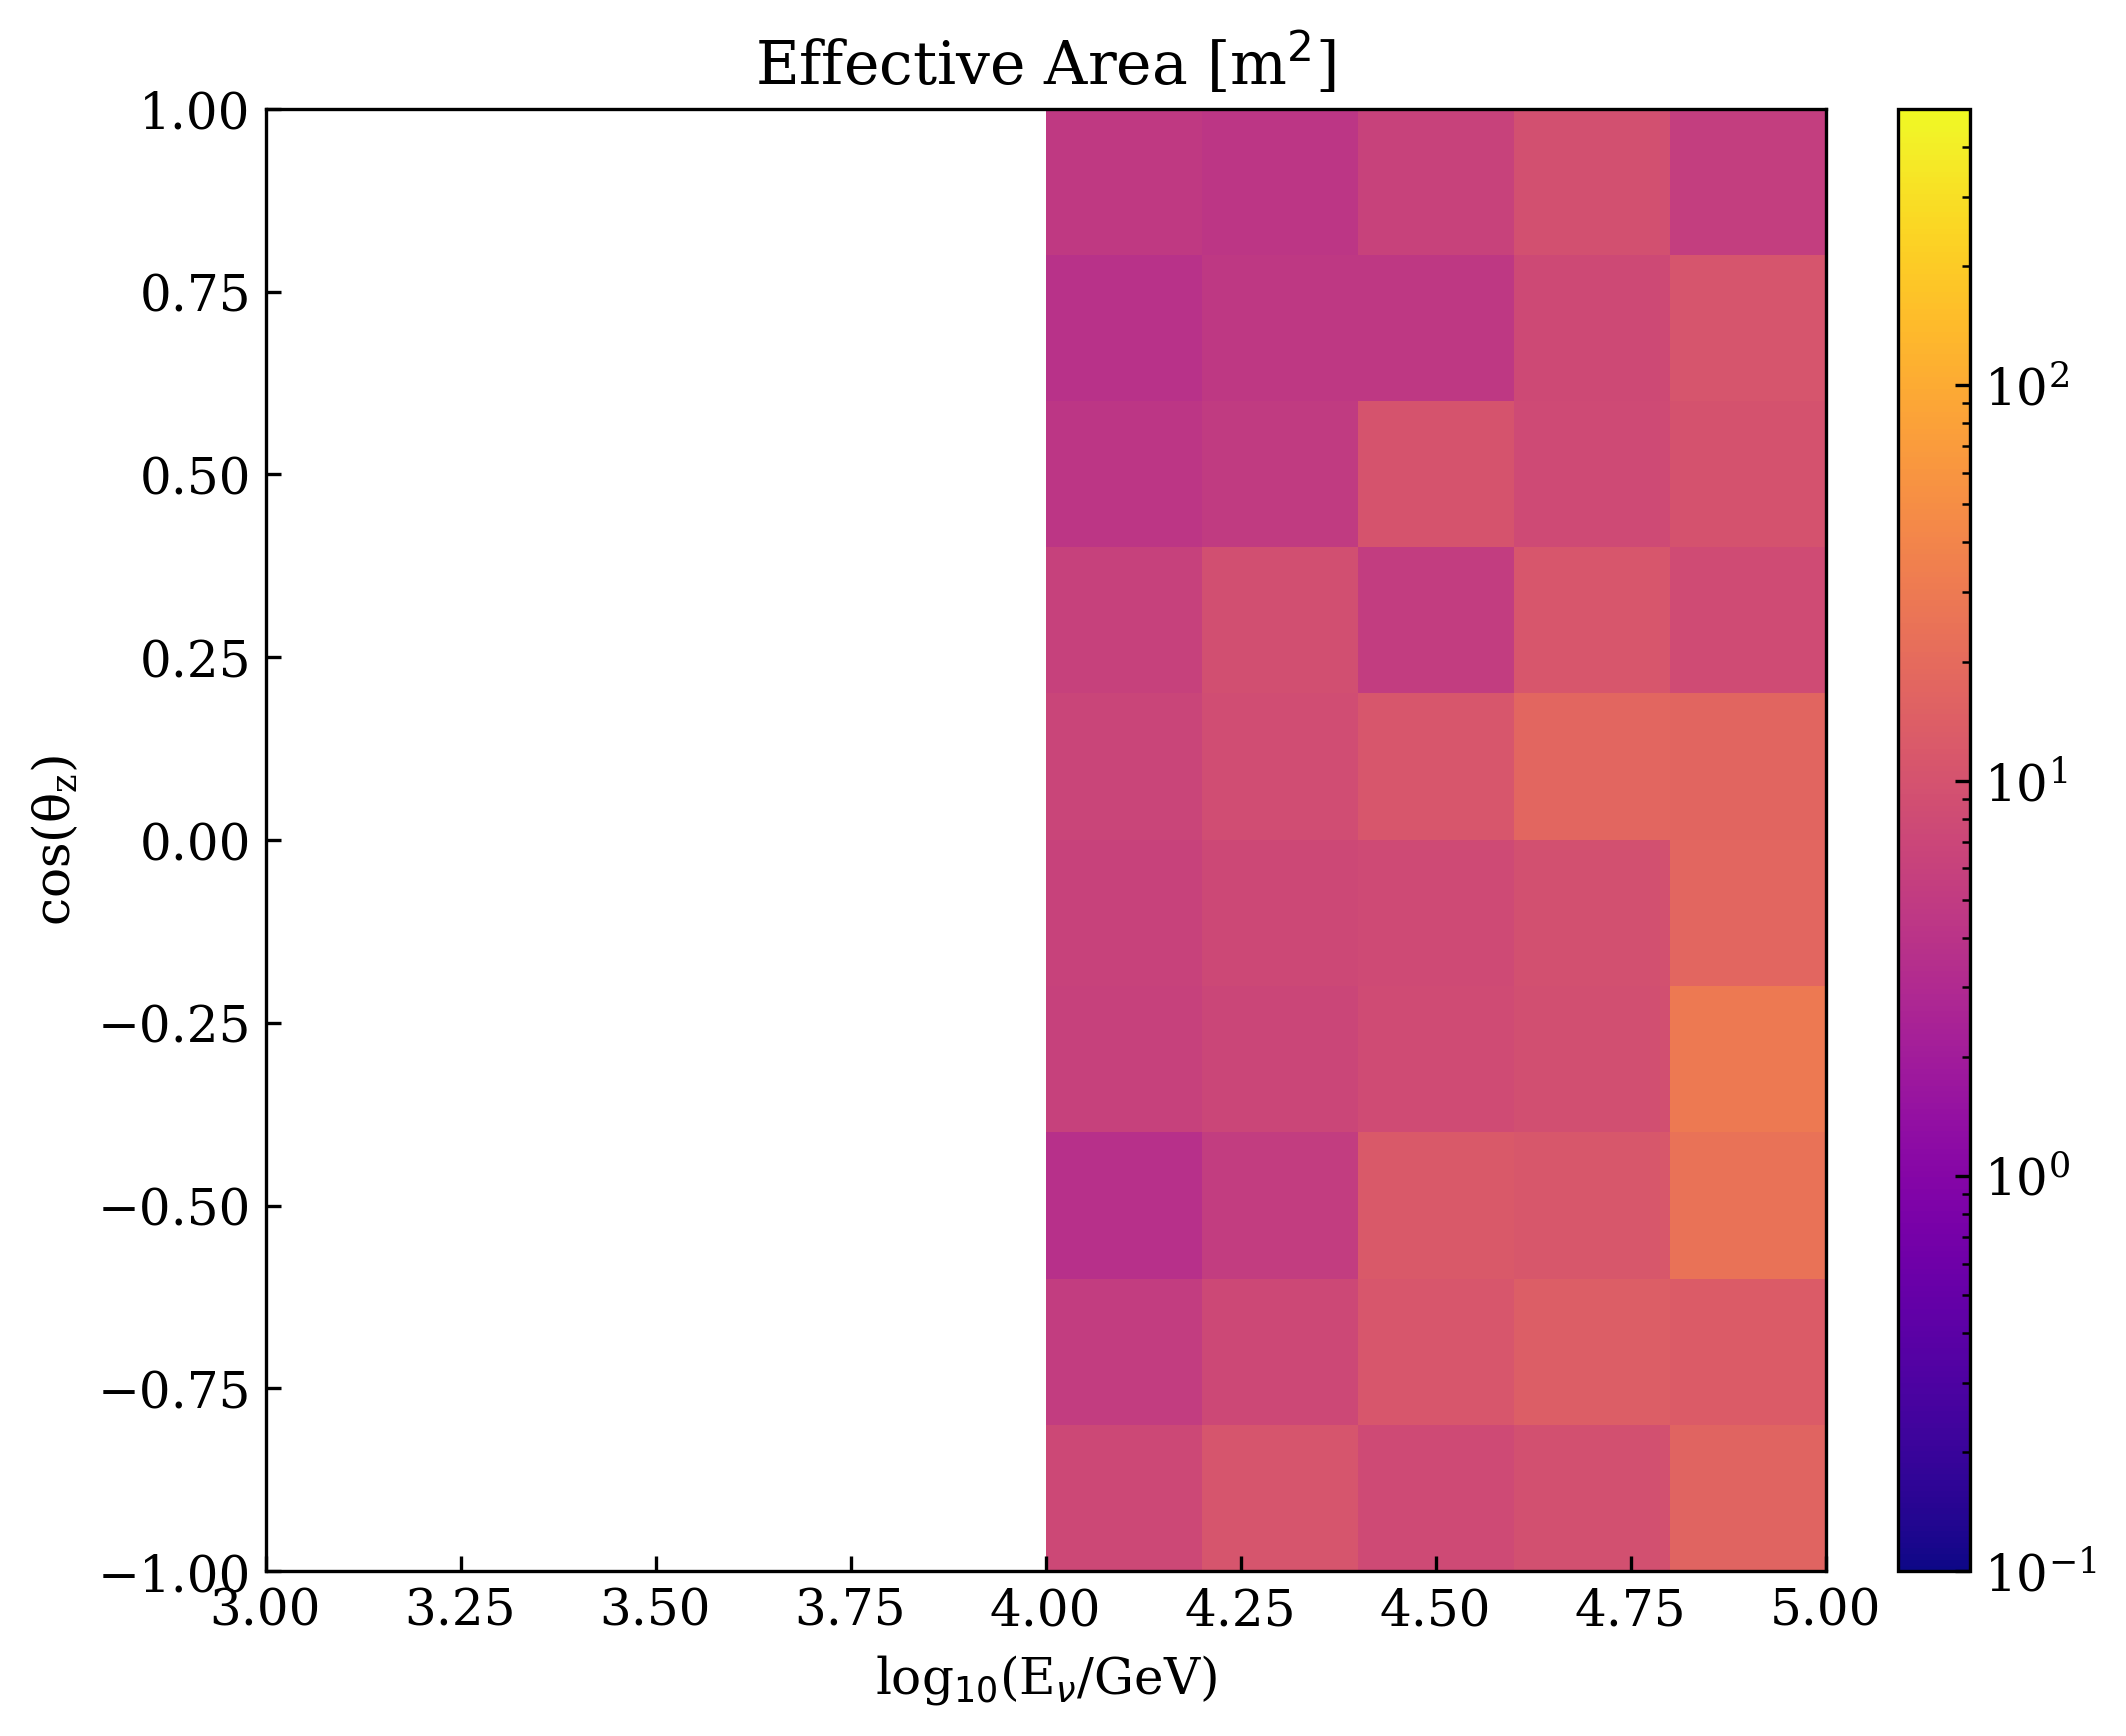

In [11]:
plot_eff_hist2d(vmin, vmax, cos_zenith_bins, log_energy_bins, file1, file2, filename)

In [12]:
def get_eff_area_band(cos_zenith_edge, cos_zenith_bins, log_energy_bins,  
                  file1: str, file2: str = None):
    effarea, log_energy = get_eff_area(cos_zenith_bins, log_energy_bins, file1, file2)
    cos_zenith = cos_zenith_bins
    log_energy_center = (
        log_energy[1:] + log_energy[:-1]) / 2
    
    n_band = len(cos_zenith_edge) - 1
    eff_area_band_avg = np.zeros(shape=(n_band, len(log_energy)-1))
    idx_zenith_self = 1
    for idx_band in range(n_band):
        cos_zenith_up = cos_zenith_edge[idx_band+1]
        num_zenith_self = 0
        eff_area_in_band = np.zeros(len(log_energy)-1)
        while (idx_zenith_self < len(cos_zenith)) and (cos_zenith[idx_zenith_self] <= cos_zenith_up):
            eff_area_in_band += effarea[idx_zenith_self-1]
            num_zenith_self += 1
            idx_zenith_self += 1
        eff_area_band_avg[idx_band] = eff_area_in_band / num_zenith_self
    return log_energy, eff_area_band_avg, log_energy_center

In [29]:
def plot_eff_hist(vmin, vmax, cos_zenith_edge, cos_zenith_bins, log_energy_bins,  
                  file1: str, file2: str = None, filename: str = None):
    log_energy, eff_area_band_avg, log_energy_center = get_eff_area_band(cos_zenith_edge, cos_zenith_bins, log_energy_bins, file1, file2)
    style="step"
    eff_area_band = eff_area_band_avg
    #print(log_energy)
    plot()
    plt.subplots(figsize=(10,6.5), dpi=300)
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for i in range(len(cos_zenith_edge)-1):
        if style == "step":
            plt.step(log_energy[:-1], eff_area_band[i]/1e4,
                        where="post", c=colors[i],
                        label=f"{cos_zenith_edge[i]:.1f}" + r"$\leq \mathregular{cos(\theta_z)} <$"+f"{cos_zenith_edge[i+1]:.1f}")
            plt.step(log_energy[1:], eff_area_band[i]/1e4,
                        where="pre", c=colors[i])
        elif style == "line":
            plt.plot(log_energy_center, eff_area_band[i]/1e4, c=colors[i],
                        label=f"{cos_zenith_edge[i]:.1f}" + r"$\leq \cos(\theta_z)<$" f"{cos_zenith_edge[i+1]:.1f}")
    plt.xlim(log_energy[0], log_energy[-1])
    plt.xlabel(r"log$_{10}$(E$_{\nu}$/GeV)")
    plt.yscale("log")
    plt.ylim(vmin, vmax)
    plt.ylabel(r"Effective area [m$^2$]")
    plt.legend()
    if filename != None:
        plt.savefig(filename + '.jpg', bbox_inches='tight')
    plt.show()
    return

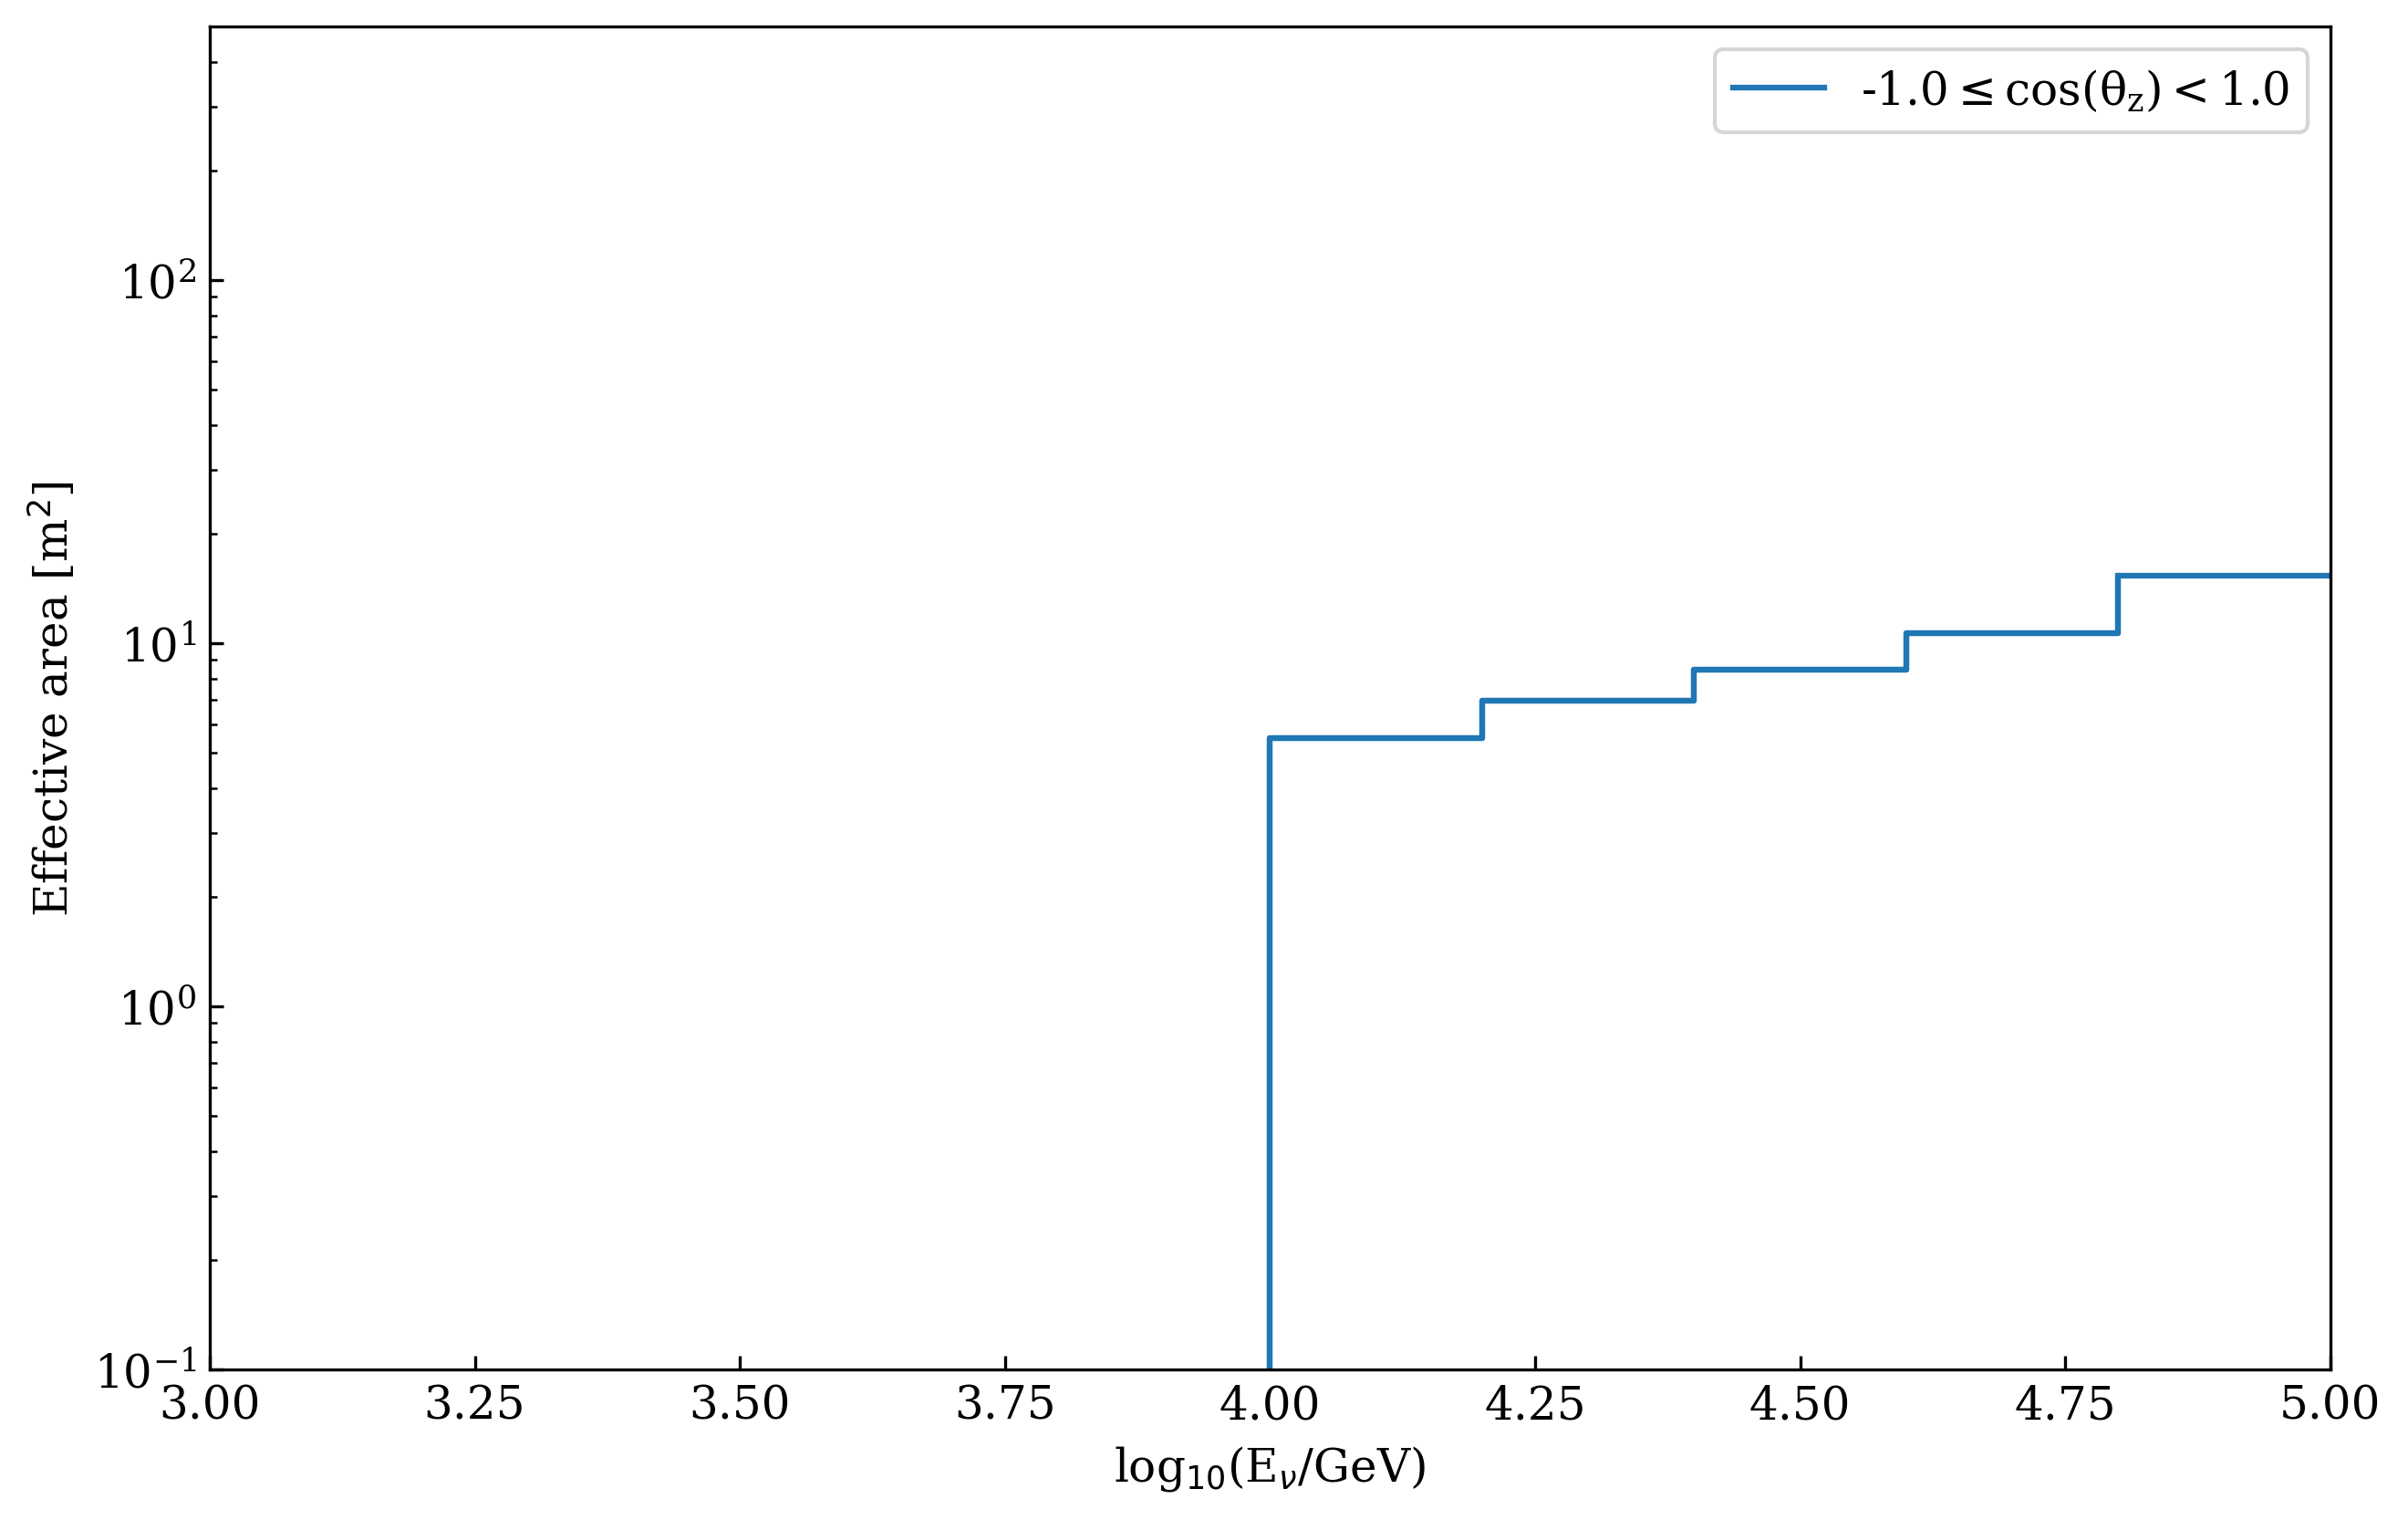

In [30]:
plot_eff_hist(vmin, vmax, cos_zenith_edge, cos_zenith_bins, log_energy_bins,  
                  file1, file2, filename)